In [1]:
import jax
import jax.numpy as np
import jax.numpy as jnp
import os
import bayes3d as b
import matplotlib.pyplot as plt

In [2]:
'''
JAX implementation of Soft Rasterizer (softras)
(c) 2021 Kartik Chandra; see MIT license attached

Soft Rasterizer: A Differentiable Renderer for Image-based 3D Reasoning
Shichen Liu, Tianye Li, Weikai Chen, and Hao Li (ICCV 2019)
https://arxiv.org/abs/1904.01786
https://github.com/ShichenLiu/SoftRas
'''

def get_pixel(left=-1, top=1, right=1., bottom=-1., xres=50, yres=50):
    '''
    Generates a grid of pixel samples in a given viewport, at a given resolution.
    
    Parameters:
        left (float): left edge of viewport
        top (float): top edge of viewport
        right (float): right edge of viewport
        bottom (float): bottom edge of viewport
        xres (int): number of samples along horizontal axis
        yres (int): number of samples along vertical axis
    Returns:
        pixel (N x 3): array of sample coordinates,
        shape (tuple): shape to reshape softras'ed outputs to get an image
    '''
    Xs = np.linspace(left, right, xres)
    Ys = np.linspace(top, bottom, yres)
    X, Y = np.meshgrid(Xs, Ys)
    Z = np.zeros_like(X)
    pixel = np.stack((X, Y, Z), axis=2).reshape(-1, 1, 3)
    return pixel, Z.shape

eps = 1e-8

def softras(mesh, pixel, C, SIGMA=1e-1, GAMMA=1e-1):
    '''
    Differentiably rasterizes a mesh using the SoftRas algorithm.
    
    Parameters:
        mesh (T x 3[face] x 3[xyz]): mesh, as list of triples of vertices
        pixel (N x 3[xyz]): pixel locations at which to render
        C (T x 3[face]): texture brightness at each face
        SIGMA (float): parameter from softras paper
        GAMMA (float): parameter from softras paper
    Returns:
        image (N): rendered pixel values, should be reshaped to form image
    '''
    Zbuf = mesh[:, :, 2]
    proj = mesh.at[:, :, 2].set(0)
    
    def dot(a, b):
        return (a * b).sum(axis=-1, keepdims=True)

    def d2_point_to_finite_edge(i):
        A = proj[:, i, :]
        B = proj[:, (i + 1) % 3, :]
        Va = B - A
        Vp = pixel - A
        projln = dot(Vp, Va) / (dot(Va, Va) + eps)
        projpt = np.clip(projln, 0, 1) * Va[None, :, :]
        out = dot(Vp - projpt, Vp - projpt)
        return out[:, :, 0]

    d2 = np.minimum(
        np.minimum(d2_point_to_finite_edge(0), d2_point_to_finite_edge(1)),
        d2_point_to_finite_edge(2)
    )
    
    def signed_area_to_point(i):
        A = proj[:, i, :]
        B = proj[:, (i + 1) % 3, :]
        Va = B - A
        area = np.cross(Va, pixel - A)[:, :, 2] / 2
        return area

    Aa = signed_area_to_point(0)
    Ab = signed_area_to_point(1)
    Ac = signed_area_to_point(2)
    Aabc = Aa + Ab + Ac + eps
    in_triangle =\
        np.equal(np.sign(Aa), np.sign(Ab)).astype('float32') *\
        np.equal(np.sign(Aa), np.sign(Ac)).astype('float32') * 2 - 1

    D = jax.nn.sigmoid(in_triangle * (d2 + 0.02) / SIGMA)

    bary = np.stack([Aa, Ab, Ac], axis=2) / Aabc[:, :, None]
    bary_clipped = np.clip(bary, 0, 1)
    bary_clipped = bary_clipped / (bary_clipped.sum(axis=2, keepdims=True) + eps)

    Zb = (bary_clipped * np.roll(Zbuf, 1, axis=1)).sum(axis=2)
    Zb = (Zb.max() - Zb) / (Zb.max() - Zb.min())

    Zbe = np.exp(np.clip(Zb / GAMMA, -20., 20.))
    DZbe = D * Zbe
    w = DZbe / (DZbe.sum(axis=1, keepdims=True) + np.exp(eps / GAMMA))
    return (w * DZbe).sum(axis=1)

In [3]:
key = jax.random.PRNGKey(7)

In [4]:
mesh_path = os.path.join(b.utils.get_assets_dir(),"sample_objs/cube.obj")
m = b.utils.load_mesh(mesh_path)
vertices = jnp.array(m.vertices)
faces = jnp.array(m.faces)
width = 100
pixel, size = get_pixel( xres=width, yres=width)
mesh = vertices[faces][:-4]
C = jax.random.uniform(jax.random.PRNGKey(3), shape=(1, mesh.shape[0]))
print(b.utils.aabb(vertices))

(Array([1., 1., 1.], dtype=float32), Array([[1., 0., 0., 0.],
       [0., 1., 0., 0.],
       [0., 0., 1., 0.],
       [0., 0., 0., 1.]], dtype=float32))


In [8]:
model_dir = os.path.join(b.utils.get_assets_dir(),"bop/ycbv/models")
idx = 14
mesh_path = os.path.join(model_dir,"obj_" + "{}".format(idx).rjust(6, '0') + ".ply")
m = b.utils.load_mesh(mesh_path)
m = b.utils.scale_mesh(m, 1.0/100.0)

vertices = jnp.array(m.vertices)
faces = jnp.array(m.faces)[:8000]
C = jax.random.uniform(jax.random.PRNGKey(3), shape=(1, mesh.shape[0]))
print(b.utils.aabb(vertices))

(Array([1.1696601 , 0.93074995, 0.81384003], dtype=float32), Array([[1., 0., 0., 0.],
       [0., 1., 0., 0.],
       [0., 0., 1., 0.],
       [0., 0., 0., 1.]], dtype=float32))


[[ 0.20626557 -0.38699603  0.89871514  0.        ]
 [ 0.5983807  -0.67682123 -0.4287815   0.        ]
 [ 0.7742063   0.62621653  0.09196615  0.        ]
 [ 0.          0.          0.          1.        ]]
[0.39414793 0.6691639  0.07897346 0.62500435]
[[ 0.2062658  -0.38699597  0.8987151 ]
 [ 0.59838074 -0.67682123 -0.42878163]
 [ 0.7742062   0.62621665  0.09196615]]


In [26]:
def render_img(quat):
    pose = b.transform_from_rot_and_pos(
        b.quaternion_to_rotation_matrix(quat),
        jnp.array([0.0, 0.0, 3.0])
    )
    vertices_transformed = b.apply_transform(vertices, pose) 
    mesh = vertices_transformed[faces]
    img = softras(mesh, pixel, C,  SIGMA=0.02, GAMMA=100.0)
    return img

[[-0.5132267   0.53777987 -0.66887313  0.        ]
 [-0.82280594 -0.529969    0.20523968  0.        ]
 [-0.24410827  0.6556872   0.7144828   0.        ]
 [ 0.          0.          0.          1.        ]]
[-0.40966052 -0.27489075  0.2592176   0.83031297]
[[-0.5132267   0.53777987 -0.66887313]
 [-0.82280594 -0.529969    0.20523968]
 [-0.24410827  0.6556872   0.7144828 ]]


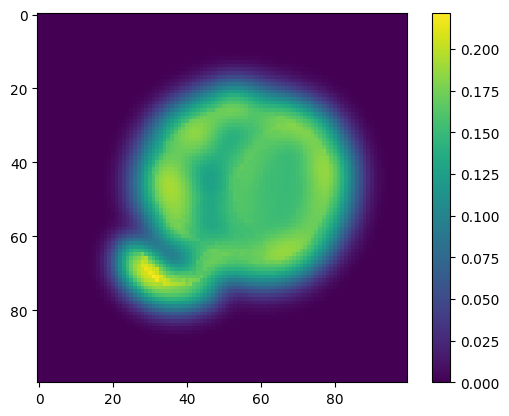

In [34]:
key = jax.random.split(key,1)[1]
R = b.distributions.vmf_jit(key, 0.0001)
print(R)
gt_orientation = b.rotation_matrix_to_quaternion(R)
print(gt_orientation)
print(b.quaternion_to_rotation_matrix(gt_orientation))
gt_img = render_img(gt_orientation)
plt.imshow(gt_img.reshape(size))
plt.colorbar()

In [35]:
def loss(quat):
    reconstruction = render_img(quat)
    return ((reconstruction - gt_img)**2).sum()
value_and_grad_loss = jax.jit(jax.value_and_grad(loss))

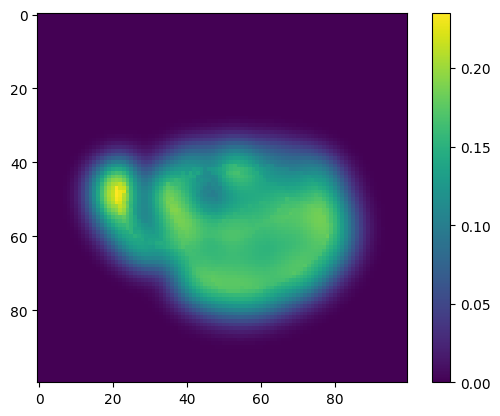

In [36]:
key = jax.random.split(key,1)[1]
R_start = b.distributions.vmf_jit(key, 0.0001)
estimated_quat = b.rotation_matrix_to_quaternion(R_start)
reconstruction = render_img(estimated_quat)
plt.imshow(reconstruction.reshape(size))
plt.colorbar()

In [37]:
quats = []
for _ in range(100):
    loss_val, gradient_quat = value_and_grad_loss(estimated_quat)
    print(loss_val)
    estimated_quat -= gradient_quat * 0.01


27.692955
11.890303
10.670499
6.290941
5.17149
4.583891
4.260175
4.016171
3.942749
3.7798905
3.7190905
3.5792503
3.5081363
3.4038837
3.341259
3.2788196
3.2287335
3.1926045
3.159134
3.140356
3.1155038
3.1067867
3.092288
3.085843
3.077944
3.0737169
3.0694027
3.0687892
3.0653558
3.0649953
3.0631764
3.0621498
3.0602548
3.0595028
3.059577
3.0585046
3.057978
3.0574322
3.0564737
3.0572805
3.0561948
3.0567527
3.0566275
3.056487
3.0564651
3.0564015
3.0571616
3.0567062
3.0571475
3.0566952
3.0573068
3.0576646
3.057284
3.0577285
3.0573287
3.057722
3.0573277
3.0577204
3.057237
3.0577202
3.0572362
3.0577202
3.0572343
3.0577207
3.0572326
3.057722
3.0572336
3.0577185
3.0572348
3.0577183
3.05723
3.0577192
3.0572355
3.0577197
3.0572388
3.057716
3.057233
3.0577188
3.0572329
3.0577188
3.057233
3.0577188
3.057233
3.0577188
3.0572329
3.0577188
3.0572329
3.0577192
3.0572348
3.0577247
3.057236
3.0577242
3.0572352
3.0577178
3.0572367
3.0577219
3.057233
3.0577154
3.0572352
3.0577211


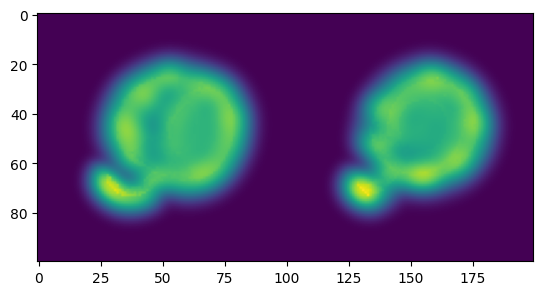

In [38]:
plt.imshow(jnp.hstack([render_img(gt_orientation).reshape(size), render_img(estimated_quat).reshape(size)]))

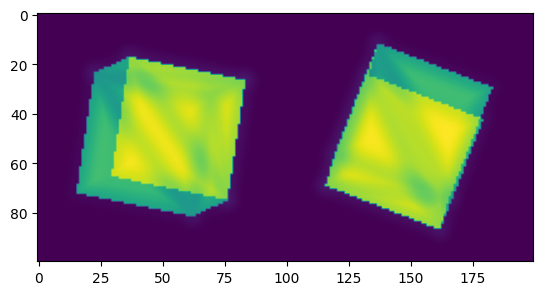

(8, 3)
(10000, 8)


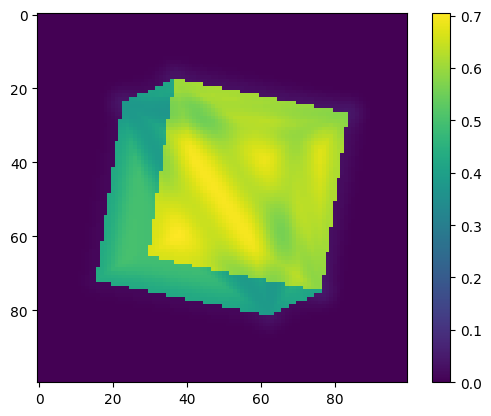

In [219]:
# key = jax.random.split(key,1)[1]
random_pose = b.distributions.vmf_jit(key, 0.0001)
vertices = b.apply_transform(vertices, random_pose) 
vertices = vertices + jnp.array([0.0, 0.0, 3.0]) 
mesh = vertices[faces][:-4]
width = 100
pixel, size = get_pixel( xres=width, yres=width)
C = jax.random.uniform(jax.random.PRNGKey(3), shape=(1, mesh.shape[0]))

img = softras(mesh, pixel, C,  SIGMA=0.01, GAMMA=10.0)
plt.imshow(img.reshape(size))
plt.colorbar()

(10000, 12)


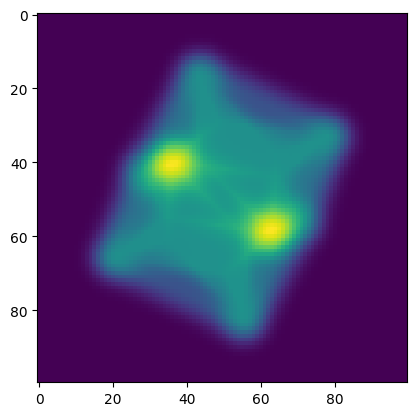

In [108]:
b.

In [11]:
from matplotlib import pyplot as plt

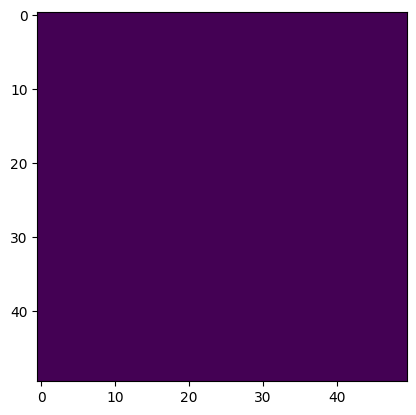

In [20]:
plt.imshow(pixel[:, 0, 2].reshape(size))

In [14]:
pixel.shape

(2500, 1, 3)

In [11]:
model_dir = os.path.join(b.utils.get_assets_dir(),"bop/ycbv/models")
idx = 14
mesh_path = os.path.join(model_dir,"obj_" + "{}".format(idx).rjust(6, '0') + ".ply")
m = b.utils.load_mesh(mesh_path)
m = b.utils.scale_mesh(m, 1.0/100.0)